# Building Random Forest and XGBoost Models 

[mahshidxyz](http://www.github.com/mahshidxyz)

October 2020

---

This study uses the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)** from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**. Using the dataset, I will train a classifier to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics. Previously, I have built a decision tree for this dataset (shared in the same repository) and achieved an accuracy of 0.82 and recall of 0.85. Here, I will use Random Forest and XGboost to improve the predictions. Random Forest and XGBoost are both ensemble learning models. Random Forest uses bagging while XGBoost uses boosting to reduce the variance in decision trees. After model optimization (hyperparameter tuning) Random Forest achieved an accuracy of 0.88 and recall of 0.85, XGBoost achieved an accuracy of 0.92 and recall of 0.88, both showing a slight improvement over the performance of the decision tree. 




**Table of contents:**

- **[Importing and Cleaning the Data](#data-import-and-cleaning)**
    
- **[Data Formatting](#format-data)**

- **[Building a Preliminary Random Forest Model](#build-rf-model)**

- **[Optimizing Parameters with Cross Validation and GridSearch](#optimize-rf-model)**

- **[Evaluating the Optimized Random Forest model](#eval-rf-model)**

- **[Building a Preliminary XGBoost Model](#build-xgb-model)**

- **[Optimizing Parameters with Cross Validation and GridSearch](#optimize-xgb-model)**

- **[Evaluating the Optimized XGBoost model](#eval-xgb-model)**


<a id="data-import-and-cleaning"></a>
# Data Import and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    roc_curve,
    plot_roc_curve,
    confusion_matrix,
    plot_confusion_matrix,
    accuracy_score,
    recall_score,
    classification_report,
)

%matplotlib inline

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("processed.cleveland.data", header=None)
# or
# df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
#                  header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Columns are not labeled. We need to add column names.
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [3]:
# labeling the columns
df.columns = [
    "age",
    "sex",
    "cp",
    "restbp",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "hd",
]

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
# explore the data
df.info()  # or df.dtypes & df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      303 non-null    float64
 1   sex      303 non-null    float64
 2   cp       303 non-null    float64
 3   restbp   303 non-null    float64
 4   chol     303 non-null    float64
 5   fbs      303 non-null    float64
 6   restecg  303 non-null    float64
 7   thalach  303 non-null    float64
 8   exang    303 non-null    float64
 9   oldpeak  303 non-null    float64
 10  slope    303 non-null    float64
 11  ca       303 non-null    object 
 12  thal     303 non-null    object 
 13  hd       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


**ca** and **thal** are expected to be numeric but are showing up as *object* type. Let's take a closer look.

In [5]:
df["ca"].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [6]:
df["thal"].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Since scikit-learn's classification trees do not support datasets with missing values we need to either drop the missing entries or impute the missing values. Since only 6 out of 303 rows are missing values we will drop the incomplete entries.

In [7]:
# see how many rows have missing values
len(df.loc[(df["ca"] == "?") | (df["thal"] == "?")])

6

In [8]:
# rows that contain missing values
df.loc[(df["ca"] == "?") | (df["thal"] == "?")]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [9]:
# drop missing values
df = df.loc[(df["ca"] != "?") & (df["thal"] != "?")]

# make sure they are gone!
for col in ["ca", "thal"]:
    print(col, "values:", df[col].unique())

ca values: ['0.0' '3.0' '2.0' '1.0']
thal values: ['6.0' '3.0' '7.0']


In [10]:
# checking hd (our dependent variable) values
# value 0 means no heart disease while other values indicate some sort of hear disease
df["hd"].unique()

array([0, 2, 1, 3, 4], dtype=int64)

<a id="format-data"></a>
# Data Formatting

## Dependent and independent variables

Since we want to build a binary classifier, we will label cases with any of the 4 types of heart diseases as class 1 and keep the no heart disease case at class 0.

In [11]:
# split the data to dependent (y) and independent (X) variables
X = df.drop("hd", axis=1)
y = df["hd"]
# relabel all 4 heart diseases (y between 1 and 4) to 1 to build a binary classifier
mask_index = y > 0
y[mask_index] = 1

## One-Hot Encoding

Categorical columns with more than two values should be one-hot-encoded (array of binary values). Otherwise their data will be treated as numeric which would cause category 1 to be considered closer to category 2 than 3, while we know that categories are not ordinal and should be treated independently. 
Note that unlike using dummy variables in regression, where we drop one column to insure columns are independent from each other, we should not drop any columns here.


- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina
  - 2 = atypical angina
  - 3 = non-anginal pain
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)


In [12]:
# making sure the values match what we expect and no data entry error exists
for col in ["cp", "restecg", "slope", "thal"]:
    print(col, "values:", X[col].unique())

cp values: [1. 4. 3. 2.]
restecg values: [2. 0. 1.]
slope values: [3. 2. 1.]
thal values: ['6.0' '3.0' '7.0']


In [13]:
# using get_dummies() on a single column
pd.get_dummies(X, columns=["cp"]).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


In [14]:
# converting all the categorical columns
X_encoded = pd.get_dummies(X, columns=["cp", "restecg", "slope", "thal"])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,0,0,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,0,0,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,0,0,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,1,0,0,0,0,1,1,0,0,1,0,0


## Convert all columns to integer, float or bool for XGBoost
RF and XGBoost require that all data be integer, float or boolean data types.

In [15]:
X_encoded.dtypes

age            float64
sex            float64
restbp         float64
chol           float64
fbs            float64
thalach        float64
exang          float64
oldpeak        float64
ca              object
cp_1.0           uint8
cp_2.0           uint8
cp_3.0           uint8
cp_4.0           uint8
restecg_0.0      uint8
restecg_1.0      uint8
restecg_2.0      uint8
slope_1.0        uint8
slope_2.0        uint8
slope_3.0        uint8
thal_3.0         uint8
thal_6.0         uint8
thal_7.0         uint8
dtype: object

In [16]:
# there is one column ca (number of major vessels) that does not satisfy datatypes that can be converted to numeric
X_encoded["ca"] = pd.to_numeric(X_encoded["ca"])

In [17]:
y.dtypes

dtype('int64')

<a id="build-rf-model"></a>
# Building a Preliminary Random Forest Model

The data is already preprocessed and ready to be used in a random forest model. 

An important difference between training a single tree and a tree within a forest is that for classification tasks, forest trees are usually trained until the leaf nodes contain one sample, or only samples from a single class. By contrast, training of a stand-alone tree usually stops before such leaf purity to avoid overfitting. Stand-alone trees may also use cross-validation and pruning to stop training. Neither are used within a forest. For regression tasks forest trees usually stop training with leaves containing five or fewer samples.

When deciding which variable to split in a forest, only certain variables are considered. If there are p predictor variables, then by default sqrt(p) are randomly chosen for consideration for each split in a classification task. In a regression task, p/3 variables are randomly chosen. The data is passed down the tree and at each node the best splitting variable is chosen. The data is partitioned according to the split to form two new nodes. This process repeats until we reach a leaf. 

So by default random forest bootstraps on the sample and for each tree selects a sample equal to the size of the original sample. Also by default no pruning is performed. It is possible to change both of these settings.

In [18]:
# let's see how balanced our dataset is
len(y[y == 1]) / len(y)

0.4612794612794613

In [19]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

In [20]:
# create an instance of a decision tree classifier and fit it to the training set
clf_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [21]:
# classification report prior to hyperparameter tuning
predicted_train = clf_rf.predict(X_train)
predicted_test = clf_rf.predict(X_test)
print("Results before hyperparameter tuning:\n")
print("training set metrics")
print(classification_report(y_train, predicted_train))
print("")
print("test set metrics")
print(classification_report(y_test, predicted_test))

Results before hyperparameter tuning:

training set metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00       104

    accuracy                           1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222


test set metrics
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.85      0.85      0.85        33

    accuracy                           0.87        75
   macro avg       0.86      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75



<a id="optimize-rf-model"></a>
# Optimizing Parameters with Cross Validation and GridSearch

Random Forest has a lot of hyperparameters, including:
* `n_estimators`: the number of trees to make
* `criterion` : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.
    Note: this parameter is tree-specific.

* `max_depth` : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split samples.

* `min_samples_split` : int or float, default=2. The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a fraction and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.

* `min_samples_leaf` : int or float, default=1
    The minimum number of samples required to be at a leaf node.
    A split point at any depth will only be considered if it leaves at
    least ``min_samples_leaf`` training samples in each of the left and
    right branches.  This may have the effect of smoothing the model,
    especially in regression.

    - If int, then consider `min_samples_leaf` as the minimum number.
    - If float, then `min_samples_leaf` is a fraction and
      `ceil(min_samples_leaf * n_samples)` are the minimum
      number of samples for each node.

* `min_weight_fraction_leaf` : float, default=0.0
    The minimum weighted fraction of the sum total of weights (of all
    the input samples) required to be at a leaf node. Samples have
    equal weight when sample_weight is not provided.

* `max_features` : {"auto", "sqrt", "log2"}, int or float, default="auto"
    The number of features to consider when looking for the best split:

    - If int, then consider `max_features` features at each split.
    - If float, then `max_features` is a fraction and
      `int(max_features * n_features)` features are considered at each
      split.
    - If "auto", then `max_features=sqrt(n_features)`.
    - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
    - If "log2", then `max_features=log2(n_features)`.
    - If None, then `max_features=n_features`.

    Note: the search for a split does not stop until at least one
    valid partition of the node samples is found, even if it requires to
    effectively inspect more than ``max_features`` features.

* `max_leaf_nodes` : int, default=None
    Grow trees with ``max_leaf_nodes`` in best-first fashion.
    Best nodes are defined as relative reduction in impurity.
    If None then unlimited number of leaf nodes.

* `min_impurity_decrease` : float, default=0.0
    A node will be split if this split induces a decrease of the impurity
    greater than or equal to this value.

    The weighted impurity decrease equation is the following::

        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)

    where ``N`` is the total number of samples, ``N_t`` is the number of
    samples at the current node, ``N_t_L`` is the number of samples in the
    left child, and ``N_t_R`` is the number of samples in the right child.

    ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
    if ``sample_weight`` is passed.
    
* `bootstrap` : default=True. Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
* `n_jobs` : The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 
* `random_state` : Controls both the randomness of the bootstrapping of the samples used
    when building trees (if ``bootstrap=True``) and the sampling of the
    features to consider when looking for the best split at each node (if ``max_features < n_features``)
* `ccp_alpha' : non-negative float, default=0.0
    Complexity parameter used for Minimal Cost-Complexity Pruning. The
    subtree with the largest cost complexity that is smaller than
    ``ccp_alpha`` will be chosen. By default, no pruning is performed.
    

Since there are many hyperparameters to optimize, I will use GridSearchCV() to tests all possible combinations of the parameters in given ranges.

In [22]:
# hyperparameter tuning

clf_rf = RandomForestClassifier(random_state=5, class_weight="balanced")
param_grid = {
    "n_estimators": [5, 10, 20, 30],
    "min_samples_split": [2, 4, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2"],
    "max_depth": [5, 6, 7, 8, 10, 15],
}

# using recall for scoring improved the recall a couple of percent for training set but not for the test set
# so I used the default which is the estimator default scoring. For RF that is accuracy
clf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=6)

clf.fit(X_train, y_train)
print(clf.best_params_)

{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 20}


<a id="eval-rf-model"></a>
# Evaluating the Optimized Random Forest Model

In [24]:
# classification report
predicted_train = clf.predict(X_train)
predicted_test = clf.predict(X_test)
print("Results after hyperparameter tuning:\n")
print("training set metrics")
print(classification_report(y_train, predicted_train))
print("")
print("test set metrics")
print(classification_report(y_test, predicted_test))

Results after hyperparameter tuning:

training set metrics
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       118
           1       0.94      0.88      0.91       104

    accuracy                           0.91       222
   macro avg       0.92      0.91      0.91       222
weighted avg       0.92      0.91      0.91       222


test set metrics
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        42
           1       0.88      0.85      0.86        33

    accuracy                           0.88        75
   macro avg       0.88      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75



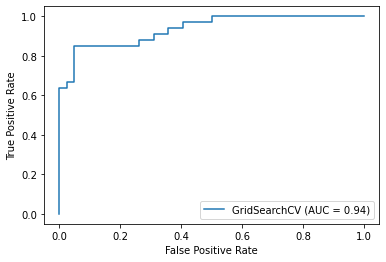

In [25]:
# ROC
plot_roc_curve(clf, X_test, y_test);

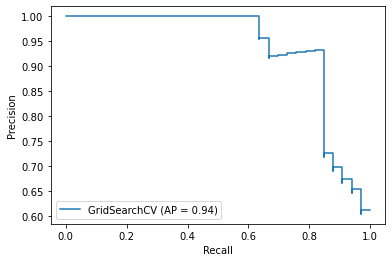

In [26]:
# precision recall
plot_precision_recall_curve(clf, X_test, y_test);

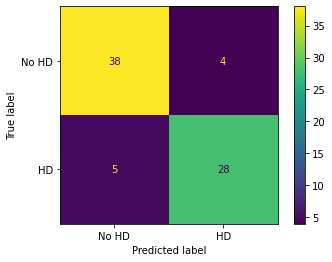

In [27]:
# confusion matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels=["No HD", "HD"]);

## Feature Importance

Feature importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other. Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function. The feature importances are then averaged across all of the decision trees within the model.

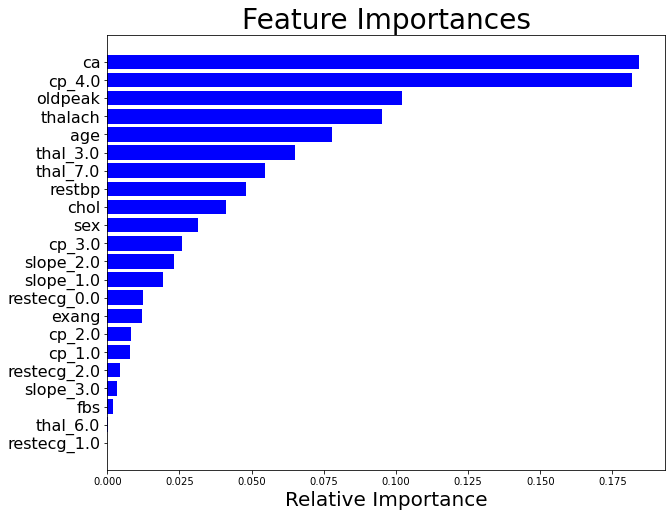

In [28]:
# plot feature importance
features = X_train.columns
best_rf = clf.best_estimator_
importances = best_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Feature Importances", fontsize=28)
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), features[indices], fontsize=16)
plt.xlabel("Relative Importance", fontsize=20);

<a id="build-xgb-model"></a>
# Building a Preliminary XGBoost Model


In [29]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

# create an instance of a decision tree classifier and fit it to the training set
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", seed=42)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [30]:
# classification report prior to hyperparameter tuning
predicted_train = clf_xgb.predict(X_train)
predicted_test = clf_xgb.predict(X_test)
print("Results before hyperparameter tuning:\n")
print("training set metrics")
print(classification_report(y_train, predicted_train))
print("")
print("test set metrics")
print(classification_report(y_test, predicted_test))

Results before hyperparameter tuning:

training set metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00       104

    accuracy                           1.00       222
   macro avg       1.00      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222


test set metrics
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        42
           1       0.82      0.85      0.84        33

    accuracy                           0.85        75
   macro avg       0.85      0.85      0.85        75
weighted avg       0.85      0.85      0.85        75



<a id="optimize-xgb-model"></a>
# Optimizing Parameters with Cross Validation and GridSearch

XGBoost has even more hyperparameters than RF. I have selected a few here:

* `n_estimators`: the number of XGBoost Trees to make
* `max_depth`: the maximum tree depth
* `learning_rate`: the learning rate, or "eta"
* `gamma`: the parameter that encourages pruning
* `reg_lambda`: the L2 regularization parameter lambda. 

I will focus on the above hyperparameters and optimize them with GridSearchCV().

In [31]:
# GridSearchCV
# currently using the default scoring metric
# For more scoring metics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# default logloss  https://xgboost.readthedocs.io/en/latest/parameter.html

param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "n_estimators": range(50, 250, 50),
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gamma": [0, 0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0],
    "reg_lambda": [0, 1.0, 10.0, 100.0, 150.0, 200.0],
}

clf = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="binary:logistic", seed=42),
    param_grid=param_grid,
    verbose=0,  # If you want to see what Grid Search is doing, set verbose=2
    n_jobs=10,
    cv=5,
)

clf.fit(X_train, y_train)
print(clf.best_params_)

{'gamma': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 150.0}


<a id="eval-xgb-model"></a>
# Evaluating the Optimized XGBoost Model

In [32]:
# classification report
predicted_train = clf.best_estimator_.predict(X_train)
predicted_test = clf.best_estimator_.predict(X_test)
print("Results after hyperparameter tuning:\n")
print("training set metrics")
print(classification_report(y_train, predicted_train))
print("")
print("test set metrics")
print(classification_report(y_test, predicted_test))

Results after hyperparameter tuning:

training set metrics
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       118
           1       0.88      0.73      0.80       104

    accuracy                           0.83       222
   macro avg       0.84      0.82      0.83       222
weighted avg       0.84      0.83      0.83       222


test set metrics
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        42
           1       0.94      0.88      0.91        33

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.92      0.92      0.92        75



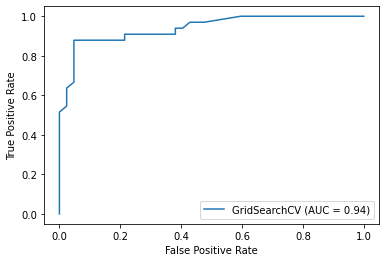

In [33]:
# ROC 
plot_roc_curve(clf, X_test, y_test);

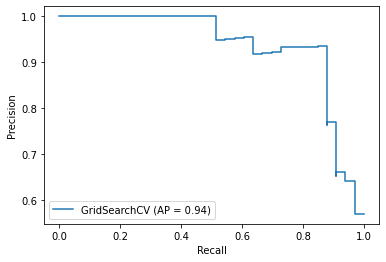

In [34]:
# precision recall curve
plot_precision_recall_curve(clf, X_test, y_test);

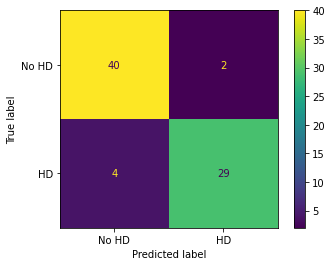

In [35]:
# confusion matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels=["No HD", "HD"]);

## Feature importance

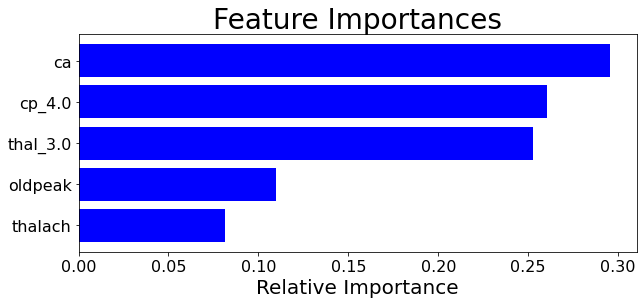

In [36]:
# feature importance

# another plot from xgboost package with a different style
# plot_importance(clf.best_estimator_, xlabel = None)

features = X_train.columns
best_xgb = clf.best_estimator_
importances = best_xgb.feature_importances_
sorted_idx = importances.argsort()
# to remove the features with zero importance
non_zero_count = len([x for x in best_xgb.feature_importances_ if x != 0])

plt.figure(figsize=(10, 4))
plt.title("Feature Importances", fontsize=28)
plt.barh(
    range(non_zero_count),
    importances[sorted_idx][-non_zero_count:],
    color="b",
    align="center",
)
plt.yticks(range(non_zero_count), features[sorted_idx][-non_zero_count:], fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel("Relative Importance", fontsize=20);